# Preprocessing — Financial Time Series

This notebook loads, processes, and visualizes financial time series from Yahoo Finance.

We will use:
- S&P 500 index (^GSPC) for price dynamics
- VIX (^VIX) as a proxy for implied volatility

These will be the inputs for our LSTM / Autoencoder / VAE models.


In [25]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import numpy as np

pd.set_option('display.max_columns', None)  # Affiche toutes les colonnes


# Download
start = "2010-01-01"
end = "2024-12-31"

sp500 = yf.download("^GSPC", start=start, end=end, progress=False)
sp500.columns = sp500.columns.droplevel(1)
vix = yf.download("^VIX", start=start, end=end, progress=False)
vix.columns = vix.columns.droplevel(1)

# Verify download
print("S&P 500 data:", sp500.shape)
print("VIX data:", vix.shape)




S&P 500 data: (3773, 5)
VIX data: (3773, 5)


/var/folders/j2/6n92hgzn6vv7rgs4fm_nk10w0000gn/T/ipykernel_2604/1472003163.py:16: FutureWarning:

YF.download() has changed argument auto_adjust default to True

/var/folders/j2/6n92hgzn6vv7rgs4fm_nk10w0000gn/T/ipykernel_2604/1472003163.py:18: FutureWarning:

YF.download() has changed argument auto_adjust default to True



## Downloading Historical Price Data

We use the `yfinance` API to download daily data from 2010 to 2024.
Tickers:
- `^GSPC`: S&P 500 index
- `^VIX`: Volatility Index


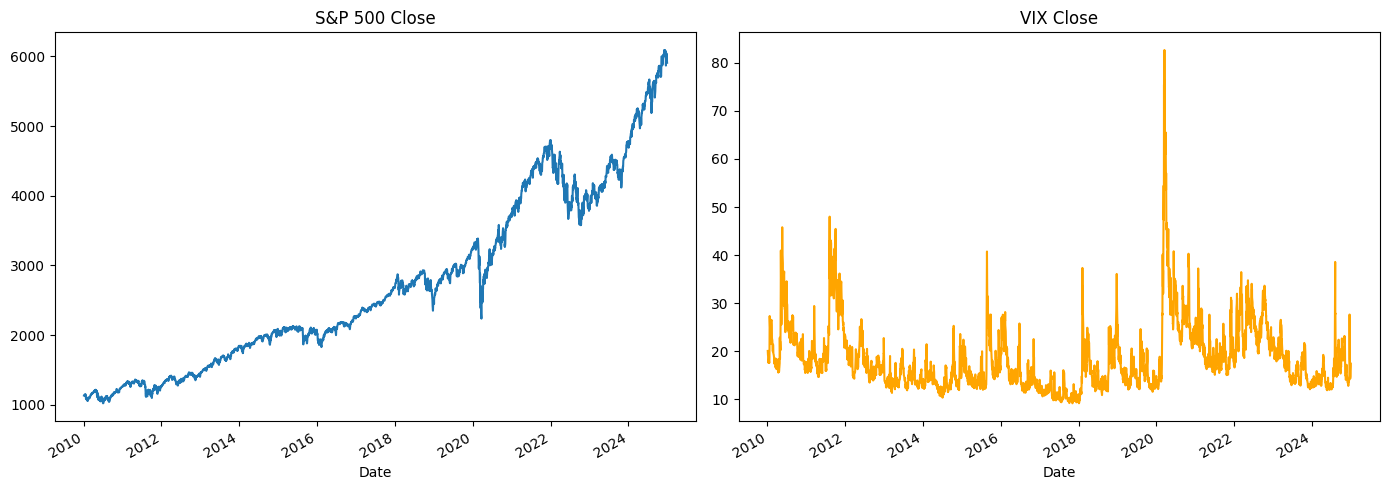

In [26]:
# Plot matplotlib version (safe fallback)
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sp500['Close'].plot(title='S&P 500 Close')
plt.subplot(1, 2, 2)
vix['Close'].plot(title='VIX Close', color='orange')
plt.tight_layout()
plt.show()

##  Candlestick Chart for S&P 500

We use Plotly to display the historical daily candlesticks of the S&P 500.
This helps visualize major regime changes and market cycles.

In [27]:
# Plotly version
fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Candlestick(
    x=sp500.index,
    open=sp500['Open'],
    high=sp500['High'],
    low=sp500['Low'],
    close=sp500['Close'],
    name='S&P 500'
))

fig.update_layout(
    title="S&P 500 Candlestick Chart (2010–2024)",
    xaxis_title="Date",
    yaxis_title="Price",
    template="plotly_dark",
    height=450
)
fig.show()


## 📈 Log Returns Calculation

We compute daily log returns as:
$$
r_{t+1} = \ln \frac{P_{t+1}}{P_t}
\quad \text{or} \quad
r_{t+1} = \ln(P_{t+1}) - \ln(P_t)
$$

$$
\begin{aligned}
r_{t+1} &= \text{log return from day } t \text{ to } t+1 \\
P_t &= \text{price at time } t \\
P_{t+1} &= \text{price at time } t+1
\end{aligned}
$$

These returns are stationary and better suited for time series modeling.

In [28]:
# Convert downloaded Yahoo Finance data to DataFrames
SP = pd.DataFrame(sp500)
Vix = pd.DataFrame(vix)

# Compute daily log returns for S&P 500
SP["log_return"] = np.log(SP["Close"] / SP["Close"].shift(1))
SP = SP.iloc[1:]

# (Here the column is named 'vix_log_diff' for clarity)
Vix["vix_log_diff"] = np.log(Vix["Close"] / Vix["Close"].shift(1))
Vix = Vix.iloc[1:]

## Feature Engineering for LSTM Model (S&P 500 & VIX)

In this notebook, we **create enriched features** from **S&P 500** and **VIX** data.  
The goal is to build a **feature set** for training an **LSTM model** to predict **log-returns**.

To provide the model with more context, we generate some **basic and typical technical indicators**:  
**MACD**, **RSI**, and **Bollinger Bands**.

These indicators capture **trend**, **momentum**, and **volatility**, which can help the LSTM model improve its forecasting performance.

---

### MACD – *Moving Average Convergence Divergence*


The **MACD** is a trend-following indicator that measures the difference between two Exponential Moving Averages (EMAs):

- Fast EMA ($ \text{EMA}_{\text{fast}} $, typically 12 periods)
- Slow EMA ($ \text{EMA}_{\text{slow}} $, typically 26 periods)

It also includes:

- **MACD Line** = difference between the two EMAs  
- **Signal Line** = EMA of the MACD line (usually 9 periods)  
- **Histogram** = MACD line – Signal line

$$
\begin{aligned}
\text{MACD}(t) &= \text{EMA}_{\text{fast}}(t) - \text{EMA}_{\text{slow}}(t) \\
\text{Signal}(t) &= \text{EMA}(\text{MACD}(t), \text{span=9}) \\
\text{Histogram}(t) &= \text{MACD}(t) - \text{Signal}(t)
\end{aligned}
$$

The EMA is computed as:

$$
\text{EMA}_t = \alpha \cdot P_t + (1-\alpha) \cdot \text{EMA}_{t-1}, \quad
\alpha = \frac{2}{\text{span}+1}
$$

#### Interpretation
- **MACD > 0** → bullish trend (fast EMA above slow EMA)  
- **MACD < 0** → bearish trend  
- **Histogram > 0** → bullish momentum increasing  
- **Histogram < 0** → bearish momentum increasing  
- **MACD crosses Signal line** → potential buy/sell signals

---

### RSI – *Relative Strength Index*

The **RSI** measures the magnitude of recent price changes to evaluate **overbought** or **oversold** conditions over a specific period (typically 14 days).

1. Price change:
$$
\Delta P_t = P_t - P_{t-1}
$$

2. Average gains and losses:
$$
\text{Gain}_t = \max(\Delta P_t, 0), \quad
\text{Loss}_t = \max(-\Delta P_t, 0)
$$

$$
\text{RS}_t = \frac{\text{Average(Gains, }n\text{)}}{\text{Average(Losses, }n\text{)} + \epsilon}
$$

3. RSI:
$$
\text{RSI}_t = 100 - \frac{100}{1 + \text{RS}_t}
$$

#### 🔹 Interpretation
- **RSI > 70** → overbought (potential bearish reversal)  
- **RSI < 30** → oversold (potential bullish reversal)  
- **RSI between 30 and 70** → neutral zone

---

### Bollinger Bands


**Bollinger Bands** measure market volatility by creating an envelope around a moving average with $ k $ standard deviations.

$$
\begin{aligned}
\text{SMA}_t &= \frac{1}{n} \sum_{i=0}^{n-1} P_{t-i} \\
\text{Upper}_t &= \text{SMA}_t + k \cdot \sigma_t \\
\text{Lower}_t &= \text{SMA}_t - k \cdot \sigma_t
\end{aligned}
$$

- $ n = 20 $ periods (default)  
- $ k = 2 $ standard deviations

#### 🔹 Interpretation
- **Price hits upper band** → potential overbought condition  
- **Price hits lower band** → potential oversold condition  
- **Bands expand** → volatility increasing  
- **Bands contract** → volatility decreasing


In [29]:
def compute_macd(series, fast=12, slow=26, signal=9):
    ema_fast = series.ewm(span=fast, min_periods=fast).mean()
    ema_slow = series.ewm(span=slow, min_periods=slow).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal, min_periods=signal).mean()
    hist = macd_line - signal_line
    return macd_line, signal_line, hist

def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0)           # garde l’index des dates
    loss = -delta.clip(upper=0)          # garde l’index des dates
    
    avg_gain = gain.rolling(window=period, min_periods=period).mean()
    avg_loss = loss.rolling(window=period, min_periods=period).mean()
    
    rs = avg_gain / (avg_loss + 1e-10)
    rsi = 100 - (100 / (1 + rs))
    
    return rsi  # Série alignée sur les dates

def compute_bollinger(series, window=20, n_std=2):
    ma = series.rolling(window=window).mean()
    std = series.rolling(window=window).std()
    upper_band = ma + n_std * std
    lower_band = ma - n_std * std
    return ma, upper_band, lower_band

macd_line, macd_signal, macd_hist = compute_macd(SP['Close'])
rsi = compute_rsi(SP['Close'])
bb_ma, bb_upper, bb_lower = compute_bollinger(SP['Close'])

Vix['vol_diff'] = Vix['Close'].diff().shift(-1)
# 1 if increase, else 0
Vix['volatility_direction'] = Vix['vol_diff'].apply(lambda x: 1 if x > 0 else 0)


features_df = pd.DataFrame({
    'SP500_Close': SP['Close'],
    'VIX_Close': Vix['Close'],
    'SP500_Volume': SP['Volume'],
    'SP500_LogRet': SP['log_return'],
    'VIX_LogRet': Vix['vix_log_diff'],
    'MACD_Line': macd_line,
    'MACD_Signal': macd_signal,
    'MACD_Hist': macd_hist,
    'RSI': rsi,
    'BB_MA': bb_ma,
    'BB_Upper': bb_upper,
    'BB_Lower': bb_lower
})

# Drop NaN rows created by rolling indicators
# Check the resulting dataset
features_df=features_df.iloc[33:]
features_df.head(5)

,SP500_Close,VIX_Close,SP500_Volume,SP500_LogRet,VIX_LogRet,MACD_Line,MACD_Signal,MACD_Hist,RSI,BB_MA,BB_Upper,BB_Lower
Date,,,,,,,,,,,,
2010-02-23,1094.599976,21.370001,4521050000,-0.012177,0.069260,-1.229232,-4.577462,3.348230,46.657477,1086.471997,1119.038738,1053.905256
2010-02-24,1105.239990,20.270000,4168360000,0.009674,-0.052846,-0.294142,-3.617750,3.323608,52.947260,1087.125494,1120.683123,1053.567866
2010-02-25,1102.939941,20.100000,4521130000,-0.002083,-0.008422,0.267727,-2.767630,3.035356,69.303062,1087.397491,1121.394489,1053.400494
2010-02-26,1104.489990,19.500000,3945190000,0.001404,-0.030305,0.821313,-1.996875,2.818189,68.841006,1088.395490,1123.200333,1053.590646
2010-03-01,1115.709961,19.260000,3847640000,0.010107,-0.012384,2.095966,-1.130688,3.226654,78.512659,1090.487488,1126.620583,1054.354393


## Normalization for Stable and Efficient Neural Networks in Time Series Forecasting

### 1. Stability and Training Speed

Recurrent neural networks such as **LSTMs** and **Autoencoders** are highly sensitive to the **scale of input features**.  
If raw data are not normalized:

- Gradients can explode or vanish  
- Training becomes slow and unstable  
- The network struggles to capture temporal dependencies

A simple first step is to normalize inputs using:

- **StandardScaler** → zero mean, unit variance  

$$
x_\text{scaled} = \frac{x - x_{\min}}{x_{\max} - x_{\min}}
$$

$$
\begin{aligned}
x_\text{scaled} &= \text{normalized value of } x \text{ in } [0,1] \\
x &= \text{original data point} \\
x_{\min} &= \text{minimum value of the feature} \\
x_{\max} &= \text{maximum value of the feature}
\end{aligned}
$$

- **MinMaxScaler** → scales features to [0, 1]

$$
x_\text{standard} = \frac{x - \mu}{\sigma}
$$

$$
\begin{aligned}
x_\text{standard} &= \text{standardized value of } x \\
x &= \text{original data point} \\
\mu &= \text{mean of the feature} \\
\sigma &= \text{standard deviation of the feature}
\end{aligned}
$$

This stabilizes training and improves convergence speed.



In [30]:
from sklearn.preprocessing import MinMaxScaler

# Initialize a Min-Max Scaler to normalize log returns between 0 and 1
scaler = MinMaxScaler()

for i in features_df.columns : 
    features_df[f'{i}_Scaled'] = scaler.fit_transform(features_df[[f'{i}']])

features_df['volatility_direction']=Vix['volatility_direction']
features_df.to_csv("../data/Cleaned_data.csv", index=True)
features_df.head(5)

,SP500_Close,VIX_Close,SP500_Volume,SP500_LogRet,VIX_LogRet,MACD_Line,MACD_Signal,MACD_Hist,RSI,BB_MA,BB_Upper,BB_Lower,SP500_Close_Scaled,VIX_Close_Scaled,SP500_Volume_Scaled,SP500_LogRet_Scaled,VIX_LogRet_Scaled,MACD_Line_Scaled,MACD_Signal_Scaled,MACD_Hist_Scaled,RSI_Scaled,BB_MA_Scaled,BB_Upper_Scaled,BB_Lower_Scaled,volatility_direction
Date,,,,,,,,,,,,,,,,,,,,,,,,,
2010-02-23,1094.599976,21.370001,4521050000,-0.012177,0.069260,-1.229232,-4.577462,3.348230,46.657477,1086.471997,1119.038738,1053.905256,0.014212,0.166281,0.425799,0.531324,0.375256,0.715377,0.691786,0.528750,0.447561,0.004022,0.001424,0.008806,0
2010-02-24,1105.239990,20.270000,4168360000,0.009674,-0.052846,-0.294142,-3.617750,3.323608,52.947260,1087.125494,1120.683123,1053.567866,0.016311,0.151326,0.392582,0.631861,0.266119,0.718214,0.695208,0.528549,0.513568,0.004154,0.001750,0.008737,0
2010-02-25,1102.939941,20.100000,4521130000,-0.002083,-0.008422,0.267727,-2.767630,3.035356,69.303062,1087.397491,1121.394489,1053.400494,0.015857,0.149014,0.425806,0.577766,0.305824,0.719918,0.698238,0.526188,0.685213,0.004208,0.001891,0.008703,0
2010-02-26,1104.489990,19.500000,3945190000,0.001404,-0.030305,0.821313,-1.996875,2.818189,68.841006,1088.395490,1123.200333,1053.590646,0.016163,0.140857,0.371563,0.593813,0.286265,0.721598,0.700986,0.524410,0.680364,0.004410,0.002249,0.008742,0
2010-03-01,1115.709961,19.260000,3847640000,0.010107,-0.012384,2.095966,-1.130688,3.226654,78.512659,1090.487488,1126.620583,1054.354393,0.018377,0.137593,0.362376,0.633856,0.302283,0.725465,0.704073,0.527755,0.781862,0.004831,0.002926,0.008898,0


### 2. Batch Normalization: First Breakthrough in Stabilization

**Batch Normalization** (Ioffe & Szegedy, 2015) was the first widely adopted solution to improve the stability of **CNNs** and **MLPs**.  
It works by:

1. Normalizing activations within each mini-batch  
2. Re-scaling and shifting them with learnable parameters

For a mini-batch : $$\mathcal{B} = \{ x_1, \dots, x_m \}$$

$$
\mu_B = \frac{1}{m} \sum_{i=1}^{m} x_i
\quad ; \quad
\sigma_B^2 = \frac{1}{m} \sum_{i=1}^{m} (x_i - \mu_B)^2
$$

$$
\hat{x}_i = \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}
\quad ; \quad
y_i = \gamma \hat{x}_i + \beta
$$

Where:  
$$
\begin{aligned}
\mu_B &= \text{mini-batch mean} \\
\sigma_B &= \text{mini-batch std} \\
\gamma &= \text{learnable scaling} \\
\beta &= \text{bias parameters}
\end{aligned}

$$

#### Limitation for RNNs

BatchNorm assumes **i.i.d. samples in a batch**, which is **not true for sequential data**.  
Directly applying it to **LSTMs** can:

- Break temporal correlations  
- Introduce instability across timesteps

---

### 3. Layer Normalization: The RNN-Friendly Approach

To solve this, **Layer Normalization** (Ba et al., 2016) was introduced.  
Instead of normalizing across the batch, it **normalizes across hidden units at a single timestep**:

$$
\text{LayerNorm}(h_t) =
\frac{h_t - \mu_t}{\sigma_t + \epsilon} \cdot \gamma + \beta
$$

Where:  
$$
\begin{aligned}
h_t \in \mathbb{R}^d &= \text{hidden state at time } t \\
\mu_t &= \text{mean across hidden dimensions} \\
\sigma_t &= \text{std across hidden dimensions} \\
\gamma &= \text{learnable scale} \\
\beta &= \text{bias parameters}
\end{aligned}
$$

#### Advantages for LSTMs

- Works even with **batch size = 1**  
- Preserves **temporal structure**  
- Improves **stability and convergence** without gradient explosion

---

#### Summary  

| Method              | Normalization Axis          | Notes                             |
|---------------------|---------------------------|-----------------------------------|
| BatchNorm           | Across **batch**           | Best for CNNs / MLPs              |
| LayerNorm           | Across **hidden units**    | Best for LSTMs / GRUs             |  

<br><br>

*Note : Layer Normalization is presented here for theoretical understanding; its practical implementation within the LSTM network will be demonstrated in a later section of this notebook. We now have normalized log-returns for S&P500 and VIX, ready for LSTM/VAE modeling*